In [9]:
import numpy as np
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

% matplotlib inline

Intro
===

This notebook showcases two different approaches to implementing coordinate descent on model defined with cross entropy loss. Coordinate descent does have problems if implemented on non-smooth multivariate functions as the algorithm may get stuck at a non-stationary points. This is because the level curves of the function are not smooth. Besides this, the algorithm does have increased interest in large-scale problems where it has been shown to be competitive to other algorithms when training support vector machines and performing non-negative matrix factorization. 

In this experiment I implement coordinate descent using the following approaches:


* Randomly optimize along a random coordinate.
* Optimize along coordinate with the largest gradient in magnitude

To benchmark the solutions I implemented a standard logistic regression model with out focusing on validation and was just used to obtain Scikit-Learns implementation of gradient descent and final loss. The model is trained with the `wine.data` dataset provided by UCI machine learning repository.

# Procedure

I use the cross entropy loss $L(w)$ in the coordinate descent method. Let $\hat{y}$ be the probability of having label 1, and let $y$ be the actual label. Then the cross entropy loss and gradient is defined below:

$$
L(w) = -\frac{1}{n}\displaystyle\sum_{i=1}^{n} y_{i} \log \hat{y}_{i} + (1 - y_{i}) \log(1 - \hat{y}_{i})
$$

And thus the gradients with respect with each weight $w_{j}$ is given by,

$$
\frac{\partial L(w)}{\partial w_{j}} = \displaystyle \sum_{i=1}^{n}(\hat{y}_{i} - y_{i})x_{j}
$$

The loss function $L(\bullet)$ should be differentiable and preferrably convex. The procedure of the Coordinate Descent method is outlined below:

* Initialize weights to zero

* Get predictions from sigmoid function

* Calculate loss and gradients

* Find Coordinate $i$ with the largest gradient in absolute value (best coordinate descent) or randomly choose weight (random coordinate descent)

* Update weight $i$ via: $w_{i} = w_{i} - \eta \frac{\partial L(w)}{\partial w_{i}}$

* Repeat (1) - (5) until convergence

In [10]:
data = np.loadtxt('./data/wine.data', delimiter=',')

X, y = data[:, 1:], data[:,0]

# tranform problem into binary classification task
idxs = [i for i in range(len(y)) if y[i] == 1 or y[i] == 2]
        
X, y = X[idxs], y[idxs]

# normalize data
X = (X - X.mean(axis=0))/(X.max(axis=0) - X.min(axis=0))
X = np.hstack((X,np.ones(len(X)).reshape(len(X),1)))

# transform target variable
y = np.array(list(map(lambda x: 0 if x == 1 else 1, y))) 

In [12]:
# scikit learn implementation (our benchmark)
reg = LogisticRegression(solver='sag', C=100000, max_iter = 10000).fit(X,y)
L_star = log_loss(y,reg.predict_proba(X))

print("Loss L* = {:<16f}".format(log_loss(y,reg.predict_proba(X))))

Loss L* = 0.000393        


We now benchmark coodinate descent algorithms off $ L^{*} \approx 0.0004$.

In [14]:
# helper functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cross_entropy_loss(y,y_pred):
    loss = -(1/len(y))*np.sum(y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred))
    return loss

def cross_entropy_grad(y,y_pred,x):
    return list(np.dot((y_pred - y),X)[0])

# Best Index

For each iteration, only update weight $w_{j}$ such that $|\frac{\partial L(w)}{\partial w_{j}}|$ is the largest for all $j$.

In [15]:
# initial weights
w = np.zeros(14).reshape(14,1)
w_rand = w

eta = 0.01
loss = []
loss_rand = []
num_iter = 1005000 # just take a bunch of iterations
for t in tqdm(range(num_iter)):
    
    # predict step 
    y_pred = sigmoid(np.dot(w.T,X.T))
    grad = cross_entropy_grad(y,y_pred,X)
    
    largest = np.argmax(np.abs(grad)) # idx with largest magnitude
    loss.append(cross_entropy_loss(y,y_pred))  
    
    # update that coordinate with largest gradient in magnitude
    w[largest] = w[largest] - eta*grad[largest]

y_pred = sigmoid(np.dot(w.T,X.T))
y_pred = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred.flatten()))) # post processing

print("Accuracy for best coordinate descent {0}".format(accuracy_score(y, y_pred)))
print("Loss L = {0}".format(loss[-1]))

100%|██████████| 1005000/1005000 [01:21<00:00, 12326.19it/s]

Accuracy for best coordinate descent 1.0
Loss L = 0.0004698390523920375


# Random Index
For each iteration, update weight $w_{j}$ for $j \in 0 \dots 13$. (e.g randomly choose a coordinate to minimize on)

In [6]:
# initial weights
w = np.zeros(14).reshape(14,1)
w_rand = w

eta = 0.01
loss_rand = []
num_iter = 1005000
for t in tqdm(range(num_iter)):
    
    # predict step
    y_pred = sigmoid(np.dot(w.T,X.T))
    loss_rand.append(cross_entropy_loss(y,y_pred))  
    grad = cross_entropy_grad(y,y_pred,X)
    random = randint(0,13)
    
    # update random coordinate
    w_rand[random] = w_rand[random] - eta*grad[random]
    
y_pred = sigmoid(np.dot(w_rand.T,X.T))
y_pred = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred.flatten())))

print("Accuracy for random coordinate descent {0}".format(accuracy_score(y, y_pred)))

100%|██████████| 1005000/1005000 [01:17<00:00, 12891.40it/s]

Accuracy for random coordinate descent 1.0


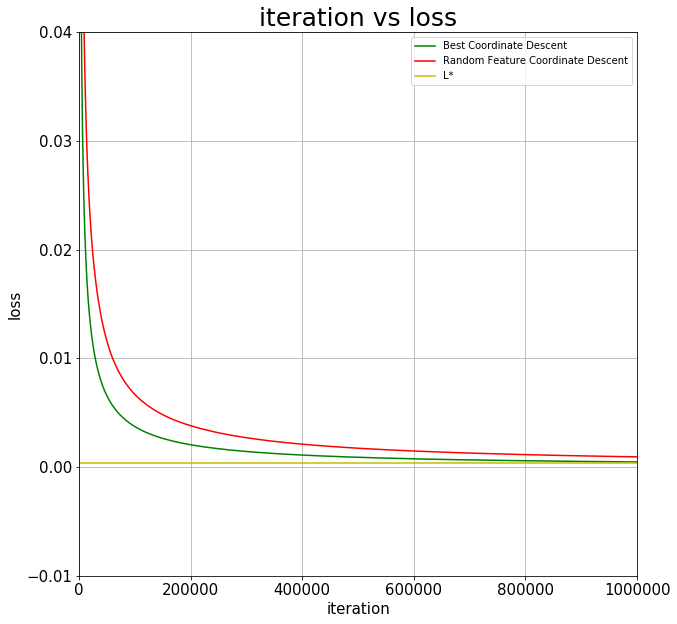

In [10]:
plt.figure(figsize=(10,10))
plt.plot(loss, 'g-', label='Best Coordinate Descent') # loss best coordinate descent
plt.plot(loss_rand, 'r-', label='Random Feature Coordinate Descent')
plt.axhline(y=L_star, color='y', label='L*')
plt.title('iteration vs loss', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.xlim(0,1000000)
plt.ylim((-0.01,0.04))
plt.ylabel('loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend()

Experimental Results
===

In this experiment I began by running an unregularized standard logistic regression solver from scikit-learn. The final cross etnropy of the logistic regression model is $L^{*} \approx 0.0004$.

In my results, after 1.5 million updates, the coordinate descent method yields a loss $L = 0.00047 \implies$ convergence to $L^{*}$. It is important to note that both implementations of Coordinate descent (random feature selection and best feature selection) converge to the loss $L^{*}$, but at different rates.

We conclude that coordinate descent is more optimally implemented if the coordinate chosen has the largest g